This code manages the observational and theoretical data of PNe IC 418 and NGC 7027.
- Observational data: fit of each observed line with a Gaussian function. This was done by the tool provided in GILDAS-CLASS.
Parameters:
    - Species: line name
    - Freq[MHz]: line frequency
    - Upper: upper level of the transition
    - Lower: lower level of the transition
    - Area: area of the line
    - Error_area: error of the area
    - Velocity: velocity of the peak
    - Error_vel: error of the velocity
    - FWHM: full width at half maximum
    - Error_FWHM: error of the FWHM
    - Tpeak: peak temperature in K (data was in Tmb)
    - Sigma: standard deviation of the Gaussian
    - RMS line: rms of the line
    - gA:
    - Delta_n: difference between the upper and lower levels
- Theoretical data: results from a ratiative transport modeling (Co3RaL) of each PNe and each element.
Parameters:
    - Species: line name
    - Freq[MHz]: line frequency
    - Vel[km/s]: velocity of the peak
    - Flux[Jy]: flux of the line
    - LTE_corr: correction factor to the LTE approximation
    - Delta_n: difference between the upper and lower levels

Definitions:
- Chemical elements: element = ['H', '3HeI', 'HeI', '3HeII', 'HeII', 'CI', 'OIII']

Data are stored in the following pandas dataframes:
- gildas_fit_data[source + 'fit'][<column_name>]: original data from GILDAS-CLASS fits
- iram[f'{source}_{e}'][<column_name>], where e is the element: IRAM-30m frequencies of GILDAS-CLASS data fits for each source and element. Tpeak is corrected and converted to Jy
- yebes[f'{source}_{e}'][<column_name>], where e is the element: Yebes-40m frequencies of GILDAS-CLASS data fits for each source and element. Tpeak is corrected and converted to Jy
- coral[f'{source}_{e}'][<column_name>], where e is the element: Co3RaL data for each source and element
- emir2[f'{source}_{e}'][<column_name>], where e is the element: EMIR-2 frequencies of GILDAS-CLASS data fits for each source and element
- emir3[f'{source}_{e}'][<column_name>], where e is the element: EMIR-3 frequencies of GILDAS-CLASS data fits for each source and element
- coral_emir2[f'{source}_{e}'][<column_name>], where e is the element: EMIR-2 frequencies of Co3RaL data for each source and element
- coral_emir3[f'{source}_{e}'][<column_name>], where e is the element: EMIR-3 frequencies of Co3RaL data for each source and element
- coral_yebes[f'{source}_{e}'][<column_name>], where e is the element: Yebes-40m frequencies of Co3RaL data for each source and element

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Importamos las librerías de rrls y manipulación de catálogos
import os
import sys
sys.path.append('/Users/teresahuertas/Documents/IAC/Python_Codes/RadioChem/')
import catalogues as cat
import Compare_Gauss_fits2 as gauss

### Definitions

In [2]:
source = 'IC418'
#source = 'NGC_7027'
element = ['H', '3HeI', 'HeI', '3HeII', 'HeII', 'CI', 'OIII']

coral_data_path = '/Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv'
gildas_fits_path = '/Users/teresahuertas/Documents/IAC/Proyectos/IRAM_2022A_158-21_Yebes_21_22A011/Ajuste_Lineas/'

### Read fits data
Read gaussian fits data obtained with GILDAS-CLASS tool and store it in a pandas dataframe. Calculate the gap between the upper and lower levels of the transition.

In [3]:
# Read data from file 'IC418_rrls_fit.csv' and save in a pandas DataFrame columns from 0 to 13
fit_files = {source + '_fit' : source + '_rrls_fit.csv'}
gildas_fit_data = {}
for file in fit_files:
    try:
        gildas_fit_data[file] = pd.read_csv(gildas_fits_path + source + '_rrls_fit.csv', sep=',',header=0, usecols=range(0,14))
    except FileNotFoundError:
        print(f"File '{source}_rrls_fit.csv' not found in path '{gildas_fits_path}'")

gildas_fit_data[source + '_fit']['Delta_n'] = gildas_fit_data[source + '_fit']['Upper'] - gildas_fit_data[source + '_fit']['Lower']
gildas_fit_data[source + '_fit'] = gildas_fit_data[source + '_fit'].reset_index(drop=True)

# Show the data
#print(gildas_fit_data)

Separate data corresponding to IRAM-30m frequencies. Convert it from Tmb to Jy

In [15]:
iram = {}
iram[source] = gildas_fit_data[source + '_fit'][gildas_fit_data[source + '_fit']['Freq[MHz]'] > 70000]
iram[source] = iram[source][iram[source]['Freq[MHz]'] < 3000000]

# Convert Tpeak data from Tmb to Ta
try:
    #TatoTmb = 1000*(94*(iram[source]['Freq[MHz]']/1000/211.024589551445843+1)+(-94-0.102592852137351087*(iram[source]['Freq[MHz]']/1000-211.024589551445843))*iram[source]['Freq[MHz]']/1000/211.024589551445843)
    #TatoTmb = TatoTmb/(-2.556567478886569763E-04*(iram[source]['Freq[MHz]']/1000)**2-7.226368939203042796E-02*(iram[source]['Freq[MHz]']/1000)+89.2508073876328893)
    iram[source]['Ta[K]'] = iram[source]['Tpeak'] / gauss.antenna_mb_temperature(iram[source]['Freq[MHz]']) #TatoTmb
    #TatomJy = 1000*(5.760273113762687692E-05*(iram[source]['Freq[MHz]']/1000)**2-5.015712414552293830E-03*(iram[source]['Freq[MHz]']/1000)+5.91822560841985812)
    iram[source]['Flux[mJy]'] = iram[source]['Ta[K]'] * gauss.mb_jy_conversion(iram[source]['Freq[MHz]']) #TatomJy
    print(f'Conversion from Tmb to mJy for {source} data done')
except ZeroDivisionError:
    print(f'Error in {source} data: dividing by zero')

# Classify the lines by species
iram[f'{source}_{element[0]}'] = iram[source][iram[source]['Species'].str.contains(r'H(?!e)')].reset_index(drop=True)
iram[f'{source}_{element[1]}'] = iram[source][iram[source]['Species'].str.contains(r'3He(?!I)')].reset_index(drop=True)
iram[f'{source}_{element[2]}'] = iram[source][iram[source]['Species'].str.contains(r'He(?!I)')].reset_index(drop=True)
iram[f'{source}_{element[3]}'] = iram[source][iram[source]['Species'].str.contains(r'3HeII')].reset_index(drop=True)
iram[f'{source}_{element[4]}'] = iram[source][iram[source]['Species'].str.contains(r'HeII')].reset_index(drop=True)
iram[f'{source}_{element[5]}'] = iram[source][iram[source]['Species'].str.contains(r'CI(?!I)')].reset_index(drop=True)
iram[f'{source}_{element[6]}'] = iram[source][iram[source]['Species'].str.contains(r'OIII')].reset_index(drop=True)

#print(iram['IC418_HeI'])

Conversion from Tmb to mJy for IC418 data done


Separate data corresponding to Yebes-40m frequencies. Convert it from Tmb to Jy

In [21]:
yebes = {}
yebes[source] = gildas_fit_data[source + '_fit'][gildas_fit_data[source + '_fit']['Freq[MHz]'] < 70000]

# Convert Tpeak data from Tmb to Ta
try:
    TatoTmb = 1.4913789244107469 - 1.2925792303656232E-002 * (yebes[source].loc[:, 'Freq[MHz]']/1000)
    TatoTmb = TatoTmb + 5.0941757966556876E-004 * (yebes[source].loc[:, 'Freq[MHz]']/1000)**2
    TatoTmb = TatoTmb * 1000
    yebes[source].loc[:, 'Ta[K]'] = yebes[source].loc[:, 'Tpeak'] / TatoTmb
    #yebes[source].loc[:, 'Ta[K]'] = yebes[source].loc[:, 'Tpeak'] / gauss.antenna_mb_temperature(yebes[source].loc[:, 'Freq[MHz]']) #TatoTmb
    TatomJy = 4.0660553594502913 -6.6879469816527315E-002 * (yebes[source].loc[:, 'Freq[MHz]']/1000)
    TatomJy = TatomJy + 1.6408850177347977E-003 * (yebes[source].loc[:, 'Freq[MHz]']/1000)**2
    TatomJy = TatomJy * 1000
    yebes[source].loc[:, 'Flux[mJy]'] = yebes[source].loc[:, 'Ta[K]'] * TatomJy
    #yebes[source].loc[:, 'Flux[mJy]'] = yebes[source].loc[:, 'Ta[K]'] * gauss.mb_jy_conversion(yebes[source].loc[:, 'Freq[MHz]']) #TatomJy
    print(f'Conversion from Tmb to mJy for {source} data done')
except ZeroDivisionError:
    print(f'Error in {source} data: dividing by zero')

# Classify the lines by species
yebes[f'{source}_{element[0]}'] = yebes[source][yebes[source]['Species'].str.contains(r'H(?!e)')].reset_index(drop=True)
yebes[f'{source}_{element[1]}'] = yebes[source][yebes[source]['Species'].str.contains(r'3He(?!I)')].reset_index(drop=True)
yebes[f'{source}_{element[2]}'] = yebes[source][yebes[source]['Species'].str.contains(r'He(?!I)')].reset_index(drop=True)
yebes[f'{source}_{element[3]}'] = yebes[source][yebes[source]['Species'].str.contains(r'3HeII')].reset_index(drop=True)
yebes[f'{source}_{element[4]}'] = yebes[source][yebes[source]['Species'].str.contains(r'HeII')].reset_index(drop=True)
yebes[f'{source}_{element[5]}'] = yebes[source][yebes[source]['Species'].str.contains(r'CI(?!I)')].reset_index(drop=True)
yebes[f'{source}_{element[6]}'] = yebes[source][yebes[source]['Species'].str.contains(r'OIII')].reset_index(drop=True)

#print(yebes_HeI[['Species', 'Tpeak']])

Conversion from Tmb to mJy for IC418 data done


/var/folders/jf/5nybs94j45q_y4qgdpfxpftw0000gp/T/ipykernel_6095/4176296909.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yebes[source].loc[:, 'Ta[K]'] = yebes[source].loc[:, 'Tpeak'] / TatoTmb
/var/folders/jf/5nybs94j45q_y4qgdpfxpftw0000gp/T/ipykernel_6095/4176296909.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yebes[source].loc[:, 'Flux[mJy]'] = yebes[source].loc[:, 'Ta[K]'] * TatomJy


### Read Co3RaL data

Read original Co3RaL data. Separate it by gaussians and calculate the area below the curve.

In [ ]:
path = '/Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/'

coral_areas = {}
data = {}
#e = 'H'
for e in element:
    coral_areas[f'{source}_{e}'] = pd.DataFrame()#columns=['Species', 'Freq[MHz]', 'Flux[Jy]', 'Delta_n'], 
                                                        #dtype={'Species': str, 'Freq[MHz]': np.float64, 'Flux[Jy]': np.float64, 'Delta_n': np.float64})
    coral_areas[f'{source}_{e}']['Species'] = 'None'
    # Read data from file 'IC418_Co3RaL_H.data'. Store the sets of data in a dictionary.
    # Each set of data starts with 'Vel[km/s]' = -93.0 and ends with 'Vel[km/s]' = 69.0
    coral_file = os.path.join(path, f'{source}_Co3RaL_{e}.data')
    if os.path.exists(coral_file):
        print(f"Reading file '{source}_Co3RaL_{e}.data' from path '{path}'")
        data[f'{source}_{e}'] = pd.read_csv(coral_file, sep=' ', header=None, names=['Freq[MHz]', 'Vel[km/s]', 'Flux[mJy]', 'LTE_corr'])
        # Add two more columns to the dataframe
        data[f'{source}_{e}']['Ta[K]'] = data[f'{source}_{e}']['Flux[mJy]'] / gauss.mb_jy_conversion(data[f'{source}_{e}']['Freq[MHz]'])
        data[f'{source}_{e}']['Tmb[K]'] = data[f'{source}_{e}']['Ta[K]'] * gauss.antenna_mb_temperature(data[f'{source}_{e}']['Freq[MHz]'])

        data2 = {}
        i = 1
        data2[f'line_{i}'] = pd.DataFrame()
        for index, row in data[f'{source}_{e}'].iterrows():
            if row['Vel[km/s]'] == -93.0:
                start = index
            if row['Vel[km/s]'] == 0.0:
                coral_areas[f'{source}_{e}'].loc[index, 'Freq[MHz]'] = row['Freq[MHz]'] #row.at['Freq[MHz]']
            if row['Vel[km/s]'] == 69.0:
                end = index+1
                data2[f'line_{i}'] = data[f'{source}_{e}'][start:end]
                #coral_areas[f'{source}_H']['Area'] = trapz(data2[i]['Flux[mJy]'], data2[i]['Freq[MHz]'])
                i += 1

        i = 1
        for index, row in coral_areas[f'{source}_{e}'].iterrows():
            coral_areas[f'{source}_{e}'].loc[index, 'Area[Ta]'] = trapz(data2[f'line_{i}']['Ta[K]'], data2[f'line_{i}']['Freq[MHz]'])
            coral_areas[f'{source}_{e}'].loc[index, 'Area[Tmb]'] = trapz(data2[f'line_{i}']['Tmb[K]'], data2[f'line_{i}']['Freq[MHz]'])
            coral_areas[f'{source}_{e}'].loc[index, 'Area[mJy]'] = trapz(data2[f'line_{i}']['Flux[mJy]'], data2[f'line_{i}']['Freq[MHz]'])
            i += 1
            #coral_areas[f'{source}_H'].loc[index, 'Area'] = trapz(data2[i]['Flux[mJy]'], data2[i]['Freq[MHz]'])

        coral_areas[f'{source}_{e}'] = coral_areas[f'{source}_H'].reset_index(drop=True)
        # Destroy the data2 dictionary
        del data2
    else:
        print(f"File '{source}_Co3RaL_{e}.data' not found in path '{path}'")
        coral_areas[f'{source}_{e}'] = pd.DataFrame()
# Show the data
#print(data2)
print(coral_areas[f'{source}_H'], coral_areas[f'{source}_HeI'], coral_areas[f'{source}_HeII'])

Read Co3RaL data from files and store it in a pandas dataframe. Create an empty dataframe if the file does not exist.

In [22]:
coral = {}

# For each element in element list, read the data from the corresponding file skipping the element if the file does not exist
# Save the data in a pandas DataFrame
for e in element:
    coral_file = os.path.join(coral_data_path, f'coral_{source}_{e}.csv')
    # Skip e if file does not exist
    if os.path.exists(coral_file):
        # Read data from file 'coral_' + source + '_' + e + '.csv' and save in a pandas DataFrame
        coral[f'{source}_{e}'] = pd.read_csv(coral_file, sep=';', header=None, names=['Species', 'Freq[MHz]', 'Vel[km/s]', 'Flux[Jy]', 'LTE_corr', 'Delta_n'])
        # Specify data types
        coral[f'{source}_{e}']['Species'] = coral[f'{source}_{e}']['Species'].astype(str)
        coral[f'{source}_{e}']['Freq[MHz]'] = pd.to_numeric(coral[f'{source}_{e}']['Freq[MHz]'], errors='coerce')
        coral[f'{source}_{e}']['Vel[km/s]'] = pd.to_numeric(coral[f'{source}_{e}']['Vel[km/s]'], errors='coerce')
        coral[f'{source}_{e}']['Flux[Jy]'] = pd.to_numeric(coral[f'{source}_{e}']['Flux[Jy]'], errors='coerce')
        coral[f'{source}_{e}']['LTE_corr'] = pd.to_numeric(coral[f'{source}_{e}']['LTE_corr'], errors='coerce')
        coral[f'{source}_{e}']['Delta_n'] = pd.to_numeric(coral[f'{source}_{e}']['Delta_n'], errors='coerce')
        # Print type of each column
        print(f'File {coral_file} read')
    else:
        coral[f'{source}_{e}'] = pd.DataFrame()
        print(f'File {coral_file} not found')

File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_H.csv read
File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_3HeI.csv not found
File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_HeI.csv read
File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_3HeII.csv not found
File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_HeII.csv not found
File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_CI.csv not found
File /Users/teresahuertas/Documents/IAC/Proyectos/Analisis_Lineas/Co3RaL_csv/coral_IC418_OIII.csv not found


### Plots

In [23]:
emir2 = {}
emir3 = {}
coral_emir2 = {}
coral_emir3 = {}
coral_yebes = {}

for e in element:
    # Skip e if the dataframe is empty
    if coral[f'{source}_{e}'].empty:
        continue
    emir2[f'{source}_{e}'] = iram[f'{source}_{e}'][iram[f'{source}_{e}']['Freq[MHz]'] > 95000]
    emir3[f'{source}_{e}'] = iram[f'{source}_{e}'][iram[f'{source}_{e}']['Freq[MHz]'] < 95000]
    emir3[f'{source}_{e}'] = emir3[f'{source}_{e}'][emir3[f'{source}_{e}']['Freq[MHz]'] > 70000]
    coral_emir2[f'{source}_{e}'] = coral[f'{source}_{e}'][coral[f'{source}_{e}']['Freq[MHz]'] > 95000]
    coral_emir3[f'{source}_{e}'] = coral[f'{source}_{e}'][coral[f'{source}_{e}']['Freq[MHz]'] < 95000]
    coral_emir3[f'{source}_{e}'] = coral_emir3[f'{source}_{e}'][coral_emir3[f'{source}_{e}']['Freq[MHz]'] > 70000]
    coral_yebes[f'{source}_{e}'] = coral[f'{source}_{e}'][coral[f'{source}_{e}']['Freq[MHz]'] < 70000]

Plots comparing the observational with the theoretical intensity of each line for each element.

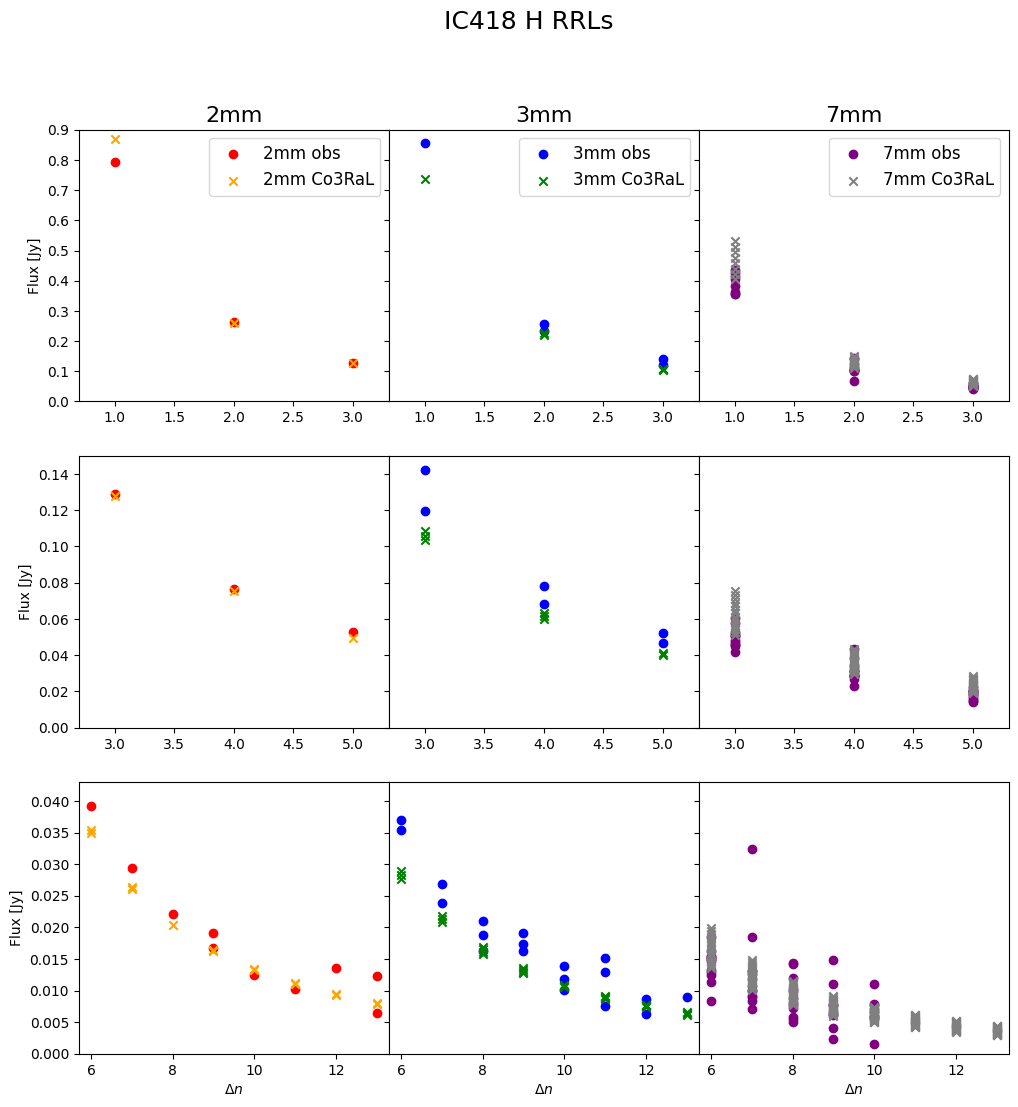

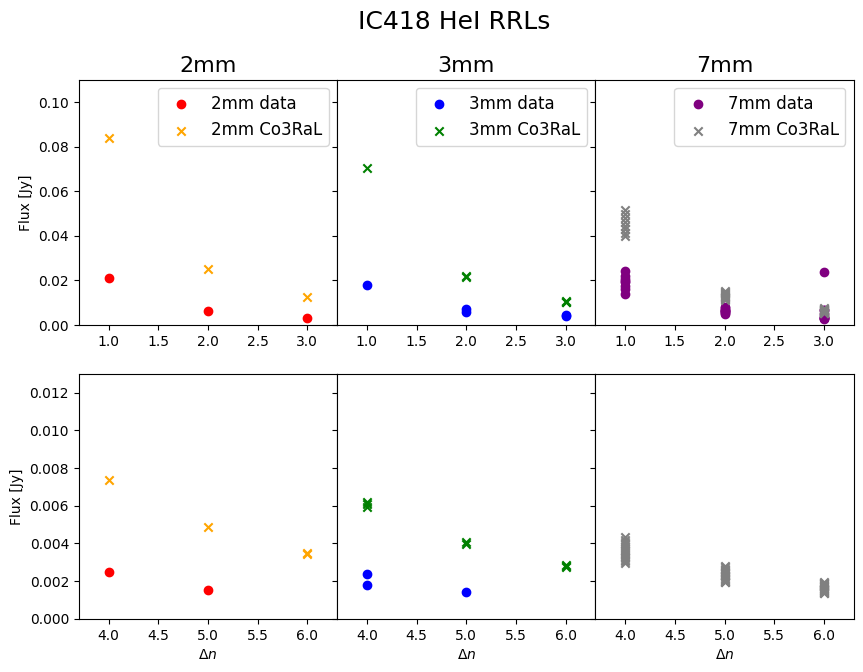

In [24]:
'''element_plot_config = {
    'H' : {'figsize': (12, 12), 'gridspec': (3, 3), 'subplots': (ax01, ax02, ax03, ax11, ax12, ax13, ax21, ax22, ax23)},
    'HeI': {'figsize': (10, 7), 'gridspec': (2, 3), 'subplots': (ax01, ax02, ax03, ax11, ax12, ax13)}
}'''

# Store x axis limits if e == 'H'
axislimits = {
    'IC418_H' : [[0.7, 3.3, 0, 0.9], [2.7, 5.3, 0, 0.15], [5.7, 13.3, 0, 0.043]],
    'IC418_HeI' : [[0.7, 3.3, 0, 0.11], [3.7, 6.3, 0, 0.013]],
    'NGC_7027_H' : [[0.7, 3.3, 0, 1.61], [2.7, 5.3, 0, 0.25], [5.7, 11.3, 0, 0.065]],
    'NGC_7027_3HeI' : [[0.7, 2.3, 0, 0.045], [2.7, 5.3, 0, 0.01]], # Set log scale instead of axislimits
    'NGC_7027_HeI' : [[0.7, 3.3, 0, 0.17], [3.7, 6.3, 0, 0.015]],
    'NGC_7027_3HeII' : [[0.7, 2.3, 0, 0.045], [2.7, 5.3, 0, 0.01]], # Set log scale instead of axislimits
    'NGC_7027_HeII' : [[0.7, 2.3, 0, 0.35], [2.7, 5.3, 0, 0.05]]
}

for e in element:
    if coral[f'{source}_{e}'].empty:
        continue

    '''config = element_plot_config[e, {}] # Use the element's configuration if available, otherwise an empty dictionary
    fig = plt.figure(figsize=config.get('figsize', (12, 12)))
    fig.suptitle(f'{source} {e} RRLs', fontsize=18)
    gs = fig.add_gridspec(*config.get('gridspec', (3, 3)), wspace=0)
    axes = config.get('subplots', gs.subplots(sharex=False, sharey='row'))'''
    if e == 'H':
        fig = plt.figure(figsize=(12, 12))
        fig.suptitle(f'{source} {e} RRLs', fontsize=18)
        gs = fig.add_gridspec(3, 3, wspace=0)
        axes = [[ax01, ax02, ax03], [ax11, ax12, ax13], [ax21, ax22, ax23]] = gs.subplots(sharex=False, sharey='row')
        # Plot in blue data with 70000 < Freq[MHz] < 95000 and in orange data with 95000 < Freq[MHz] < 3000000
        ax01.scatter(emir2[f'{source}_{e}']['Delta_n'], emir2[f'{source}_{e}']['Flux[mJy]'], c='red', label='2mm obs')
        ax01.scatter(coral_emir2[f'{source}_{e}']['Delta_n'], coral_emir2[f'{source}_{e}']['Flux[Jy]'], c='orange', marker='x', label='2mm Co3RaL')
        ax02.scatter(emir3[f'{source}_{e}']['Delta_n'], emir3[f'{source}_{e}']['Flux[mJy]'], c='blue', label='3mm obs')
        ax02.scatter(coral_emir3[f'{source}_{e}']['Delta_n'], coral_emir3[f'{source}_{e}']['Flux[Jy]'], c='green', marker='x', label='3mm Co3RaL')
        ax03.scatter(yebes[f'{source}_{e}']['Delta_n'], yebes[f'{source}_{e}']['Flux[mJy]'], c='purple', label='7mm obs')
        ax03.scatter(coral_yebes[f'{source}_{e}']['Delta_n'], coral_yebes[f'{source}_{e}']['Flux[Jy]'], c='gray', marker='x', label='7mm Co3RaL')
        ax11.scatter(emir2[f'{source}_{e}']['Delta_n'], emir2[f'{source}_{e}']['Flux[mJy]'], c='red', label='2mm obs')
        ax11.scatter(coral_emir2[f'{source}_{e}']['Delta_n'], coral_emir2[f'{source}_{e}']['Flux[Jy]'], c='orange', marker='x', label='2mm Co3RaL')
        ax12.scatter(emir3[f'{source}_{e}']['Delta_n'], emir3[f'{source}_{e}']['Flux[mJy]'], c='blue', label='3mm obs')
        ax12.scatter(coral_emir3[f'{source}_{e}']['Delta_n'], coral_emir3[f'{source}_{e}']['Flux[Jy]'], c='green', marker='x', label='3mm Co3RaL')
        ax13.scatter(yebes[f'{source}_{e}']['Delta_n'], yebes[f'{source}_{e}']['Flux[mJy]'], c='purple', label='7mm obs')
        ax13.scatter(coral_yebes[f'{source}_{e}']['Delta_n'], coral_yebes[f'{source}_{e}']['Flux[Jy]'], c='gray', marker='x', label='7mm Co3RaL')
        ax21.scatter(emir2[f'{source}_{e}']['Delta_n'], emir2[f'{source}_{e}']['Flux[mJy]'], c='red', label='2mm obs')
        ax21.scatter(coral_emir2[f'{source}_{e}']['Delta_n'], coral_emir2[f'{source}_{e}']['Flux[Jy]'], c='orange', marker='x', label='2mm Co3RaL')
        ax22.scatter(emir3[f'{source}_{e}']['Delta_n'], emir3[f'{source}_{e}']['Flux[mJy]'], c='blue', label='3mm obs')
        ax22.scatter(coral_emir3[f'{source}_{e}']['Delta_n'], coral_emir3[f'{source}_{e}']['Flux[Jy]'], c='green', marker='x', label='3mm Co3RaL')
        ax23.scatter(yebes[f'{source}_{e}']['Delta_n'], yebes[f'{source}_{e}']['Flux[mJy]'], c='purple', label='7mm obs')
        ax23.scatter(coral_yebes[f'{source}_{e}']['Delta_n'], coral_yebes[f'{source}_{e}']['Flux[Jy]'], c='gray', marker='x', label='7mm Co3RaL')
        
        # Set axis limits
        for i, row in enumerate(axes):
            for j, ax in enumerate(row):
                #e = element[i * 3 + j]
                ax.axis(axislimits[f'{source}_{e}'][i])

        ax01.set(ylabel='Flux [Jy]')
        ax11.set(ylabel='Flux [Jy]')
        ax21.set(ylabel='Flux [Jy]', xlabel=r'$\Delta n$')
        ax22.set(xlabel=r'$\Delta n$')
        ax23.set(xlabel=r'$\Delta n$')
    elif e == 'HeI':
        fig = plt.figure(figsize=(10, 7))
        fig.suptitle(f'{source} {e} RRLs', fontsize=18)
        gs = fig.add_gridspec(2, 3, wspace=0)
        axes = [[ax01, ax02, ax03], [ax11, ax12, ax13]] = gs.subplots(sharex=False, sharey='row')
        ax01.scatter(emir2[f'{source}_{e}']['Delta_n'], emir2[f'{source}_{e}']['Tpeak'], c='red', label='2mm data')
        ax01.scatter(coral_emir2[f'{source}_{e}']['Delta_n'], coral_emir2[f'{source}_{e}']['Flux[Jy]'], c='orange', marker='x', label='2mm Co3RaL')
        ax02.scatter(emir3[f'{source}_{e}']['Delta_n'], emir3[f'{source}_{e}']['Tpeak'], c='blue', label='3mm data')
        ax02.scatter(coral_emir3[f'{source}_{e}']['Delta_n'], coral_emir3[f'{source}_{e}']['Flux[Jy]'], c='green', marker='x', label='3mm Co3RaL')
        ax03.scatter(yebes[f'{source}_{e}']['Delta_n'], yebes[f'{source}_{e}']['Tpeak'], c='purple', label='7mm data')
        ax03.scatter(coral_yebes[f'{source}_{e}']['Delta_n'], coral_yebes[f'{source}_{e}']['Flux[Jy]'], c='gray', marker='x', label='7mm Co3RaL')
        ax11.scatter(emir2[f'{source}_{e}']['Delta_n'], emir2[f'{source}_{e}']['Tpeak'], c='red', label='2mm data')
        ax11.scatter(coral_emir2[f'{source}_{e}']['Delta_n'], coral_emir2[f'{source}_{e}']['Flux[Jy]'], c='orange', marker='x', label='2mm Co3RaL')
        ax12.scatter(emir3[f'{source}_{e}']['Delta_n'], emir3[f'{source}_{e}']['Tpeak'], c='blue', label='3mm data')
        ax12.scatter(coral_emir3[f'{source}_{e}']['Delta_n'], coral_emir3[f'{source}_{e}']['Flux[Jy]'], c='green', marker='x', label='3mm Co3RaL')
        ax13.scatter(yebes[f'{source}_{e}']['Delta_n'], yebes[f'{source}_{e}']['Tpeak'], c='purple', label='7mm data')
        ax13.scatter(coral_yebes[f'{source}_{e}']['Delta_n'], coral_yebes[f'{source}_{e}']['Flux[Jy]'], c='gray', marker='x', label='7mm Co3RaL')

        # Se axis limits
        for i, row in enumerate(axes):
            for j, ax in enumerate(row):
                #e = element[i * 3 + j]
                ax.axis(axislimits[f'{source}_{e}'][i])

        ax01.set(ylabel='Flux [Jy]')
        ax11.set(ylabel='Flux [Jy]', xlabel=r'$\Delta n$')
        ax12.set(xlabel=r'$\Delta n$')
        ax13.set(xlabel=r'$\Delta n$')
    ax01.set_title('2mm', fontsize=16)
    ax02.set_title('3mm', fontsize=16)
    ax03.set_title('7mm', fontsize=16)
    ax01.legend(fontsize=12)
    ax02.legend(fontsize=12)
    ax03.legend(fontsize=12)
#ax.grid()
plt.show()

In [ ]:
obs_data = {}
for e in element:
    if coral[f'{source}_{e}'].empty:
        obs_data[f'{source}_{e}'] = pd.DataFrame()
        print(f'Created empty dataframe for {e}')
        continue
    obs_data[f'{source}_{e}'] = pd.concat([yebes[f'{source}_{e}'], iram[f'{source}_{e}']])
    print(f'Obs data concatenated for {e}')

ratios_elements = {}
ratios_elements_emir2 = {}
ratios_elements_emir3 = {}
ratios_elements_yebes = {}
for e in element:
    # Explicitly set the data type of the columns: 'Species' as string and 'Fre[MHz]', 'Flux[Jy]' and 'Delta_n' as numeric
    ratios_elements[f'{source}_{e}'] = pd.DataFrame()#columns=['Species', 'Freq[MHz]', 'Flux[Jy]', 'Delta_n'], 
                                                    #dtype={'Species': str, 'Freq[MHz]': np.float64, 'Flux[Jy]': np.float64, 'Delta_n': np.float64})
    if coral[f'{source}_{e}'].empty or obs_data[f'{source}_{e}'].empty:
        #ratios_elements[f'{source}_{e}'] = pd.DataFrame()
        ratios_elements_emir2[f'{source}_{e}'] = pd.DataFrame()
        ratios_elements_emir3[f'{source}_{e}'] = pd.DataFrame()
        ratios_elements_yebes[f'{source}_{e}'] = pd.DataFrame()
        print(f'Created empty dataframes for {e} ratios')
        continue
    for index, row in obs_data[f'{source}_{e}'].iterrows():
        for index2, row2 in coral[f'{source}_{e}'].iterrows():
            if row['Species'] == row2['Species']:
                try:
                    ratios_elements[f'{source}_{e}'].loc[index, 'Species'] = row['Species']
                    ratios_elements[f'{source}_{e}'].loc[index, 'Freq[MHz]'] = row['Freq[MHz]']
                    ratios_elements[f'{source}_{e}'].loc[index, 'Flux[Jy]'] = row['Flux[mJy]']/row2['Flux[Jy]']
                    ratios_elements[f'{source}_{e}'].loc[index, 'Delta_n'] = row['Delta_n']
                except ZeroDivisionError:
                    continue
    ratios_elements_emir2[f'{source}_{e}'] = ratios_elements[f'{source}_{e}'][ratios_elements[f'{source}_{e}']['Freq[MHz]'] > 95000]
    ratios_elements_emir3[f'{source}_{e}'] = ratios_elements[f'{source}_{e}'][ratios_elements[f'{source}_{e}']['Freq[MHz]'] < 95000]
    ratios_elements_emir3[f'{source}_{e}'] = ratios_elements_emir3[f'{source}_{e}'][ratios_elements_emir3[f'{source}_{e}']['Freq[MHz]'] > 70000]
    ratios_elements_yebes[f'{source}_{e}'] = ratios_elements[f'{source}_{e}'][ratios_elements[f'{source}_{e}']['Freq[MHz]'] < 70000]
    print(f'Calculated ratios for {e} and separated by frequencies')

ratios_obs = {}
ratios_obs_emir2 = {}
ratios_obs_emir3 = {}
ratios_obs_yebes = {}
ratios_obs[f'{source}_{element[0]}/{element[2]}'] = pd.DataFrame()
for index, row in obs_data[f'{source}_{element[0]}'].iterrows():
    for index2, row2 in obs_data[f'{source}_{element[2]}'].iterrows():
        try:
            ratios_obs[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Species'] = f'{row['Species']}/{row2['Species']}'
            ratios_obs[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Freq[MHz]'] = row['Freq[MHz]']
            ratios_obs[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Flux[Jy]'] = row['Flux[mJy]']/row2['Tpeak']
            ratios_obs[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Delta_n'] = row['Delta_n']
        except ZeroDivisionError:
            continue
ratios_obs_emir2[f'{source}_{element[0]}/{element[2]}'] = ratios_obs[f'{source}_{element[0]}/{element[2]}'][ratios_obs[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] > 95000]
ratios_obs_emir3[f'{source}_{element[0]}/{element[2]}'] = ratios_obs[f'{source}_{element[0]}/{element[2]}'][ratios_obs[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] < 95000]
ratios_obs_emir3[f'{source}_{element[0]}/{element[2]}'] = ratios_obs_emir3[f'{source}_{element[0]}/{element[2]}'][ratios_obs_emir3[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] > 70000]
ratios_obs_yebes[f'{source}_{element[0]}/{element[2]}'] = ratios_obs[f'{source}_{element[0]}/{element[2]}'][ratios_obs[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] < 70000]
print(f'Calculated ratios for observed {element[0]}/{element[2]} lines and separated by frequencies')
# Calculate ratios starting from element[1] to element[4]
# Ratios are calculated as the flux of element[i] divided by the flux of element[i+1]
for i in range(1, 4):
    ratios_obs[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
    if obs_data[f'{source}_{element[i]}'].empty or obs_data[f'{source}_{element[i+1]}'].empty:
        ratios_obs_emir2[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
        ratios_obs_emir3[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
        ratios_obs_yebes[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
        print(f'Created empty dataframes for {element[i]}/{element[i+1]} ratios')
        continue
    for index, row in obs_data[f'{source}_{element[i]}'].iterrows():
        for index2, row2 in obs_data[f'{source}_{element[i+1]}'].iterrows():
            try:
                ratios_obs[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Species'] = f'{row['Species']}/{row2['Species']}'
                ratios_obs[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Freq[MHz]'] = row['Freq[MHz]']
                ratios_obs[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Flux[Jy]'] = row['Flux[mJy]']/row2['Tpeak']
                ratios_obs[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Delta_n'] = row['Delta_n']
            except ZeroDivisionError:
                continue
    ratios_obs_emir2[f'{source}_{element[i]}/{element[i+1]}'] = ratios_obs[f'{source}_{element[i]}/{element[i+1]}'][ratios_obs[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] > 95000]
    ratios_obs_emir3[f'{source}_{element[i]}/{element[i+1]}'] = ratios_obs[f'{source}_{element[i]}/{element[i+1]}'][ratios_obs[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] < 95000]
    ratios_obs_emir3[f'{source}_{element[i]}/{element[i+1]}'] = ratios_obs_emir3[f'{source}_{element[i]}/{element[i+1]}'][ratios_obs_emir3[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] > 70000]
    ratios_obs_yebes[f'{source}_{element[i]}/{element[i+1]}'] = ratios_obs[f'{source}_{element[i]}/{element[i+1]}'][ratios_obs[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] < 70000]
    print(f'Calculated ratios for observed {element[i]}/{element[i+1]} lines and separated by frequencies')

ratios_coral = {}
ratios_coral_emir2 = {}
ratios_coral_emir3 = {}
ratios_coral_yebes = {}
ratios_coral[f'{source}_{element[0]}/{element[2]}'] = pd.DataFrame()
for index, row in coral[f'{source}_{element[0]}'].iterrows():
    for index2, row2 in coral[f'{source}_{element[2]}'].iterrows():
        try:
            ratios_coral[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Species'] = f'{row['Species']}/{row2['Species']}'
            ratios_coral[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Freq[MHz]'] = row['Freq[MHz]']
            ratios_coral[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Flux[Jy]'] = row['Flux[Jy]']/row2['Flux[Jy]']
            ratios_coral[f'{source}_{element[0]}/{element[2]}'].loc[index, 'Delta_n'] = row['Delta_n']
        except ZeroDivisionError:
            continue
ratios_coral_emir2[f'{source}_{element[0]}/{element[2]}'] = ratios_coral[f'{source}_{element[0]}/{element[2]}'][ratios_coral[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] > 95000]
ratios_coral_emir3[f'{source}_{element[0]}/{element[2]}'] = ratios_coral[f'{source}_{element[0]}/{element[2]}'][ratios_coral[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] < 95000]
ratios_coral_emir3[f'{source}_{element[0]}/{element[2]}'] = ratios_coral_emir3[f'{source}_{element[0]}/{element[2]}'][ratios_coral_emir3[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] > 70000]
ratios_coral_yebes[f'{source}_{element[0]}/{element[2]}'] = ratios_coral[f'{source}_{element[0]}/{element[2]}'][ratios_coral[f'{source}_{element[0]}/{element[2]}']['Freq[MHz]'] < 70000]
print(f'Calculated ratios for Co3RaL {element[0]}/{element[2]} lines and separated by frequencies')
# Calculate ratios starting from element[1] to element[4]
# Ratios are calculated as the flux of element[i] divided by the flux of element[i+1]
for i in range(1, 4):
    ratios_coral[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
    if coral[f'{source}_{element[i]}'].empty or coral[f'{source}_{element[i+1]}'].empty:
        ratios_coral_emir2[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
        ratios_coral_emir3[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
        ratios_coral_yebes[f'{source}_{element[i]}/{element[i+1]}'] = pd.DataFrame()
        print(f'Created empty dataframes for {element[i]}/{element[i+1]} Co3RaL ratios')
        continue
    for index, row in coral[f'{source}_{element[i]}'].iterrows():
        for index2, row2 in coral[f'{source}_{element[i+1]}'].iterrows():
            # Skip division by zero
            try:
                ratios_coral[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Species'] = f'{row['Species']}/{row2['Species']}'
                ratios_coral[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Freq[MHz]'] = row['Freq[MHz]']
                ratios_coral[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Flux[Jy]'] = row['Flux[Jy]']/row2['Flux[Jy]']
                ratios_coral[f'{source}_{element[i]}/{element[i+1]}'].loc[index, 'Delta_n'] = row['Delta_n']
            except ZeroDivisionError:
                continue
    ratios_coral_emir2[f'{source}_{element[i]}/{element[i+1]}'] = ratios_coral[f'{source}_{element[i]}/{element[i+1]}'][ratios_coral[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] > 95000]
    ratios_coral_emir3[f'{source}_{element[i]}/{element[i+1]}'] = ratios_coral[f'{source}_{element[i]}/{element[i+1]}'][ratios_coral[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] < 95000]
    ratios_coral_emir3[f'{source}_{element[i]}/{element[i+1]}'] = ratios_coral_emir3[f'{source}_{element[i]}/{element[i+1]}'][ratios_coral_emir3[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] > 70000]
    ratios_coral_yebes[f'{source}_{element[i]}/{element[i+1]}'] = ratios_coral[f'{source}_{element[i]}/{element[i+1]}'][ratios_coral[f'{source}_{element[i]}/{element[i+1]}']['Freq[MHz]'] < 70000]
    print(f'Calculated ratios for Co3RaL {element[i]}/{element[i+1]} lines and separated by frequencies')


Plots showing the ratios of observational/theoretical intensity of each line for each element, observational/observational intensity of elements and theoretical/theoretical intensity of elements.

In [ ]:
axislimits = {
    'IC418' : [[0, 14, 0, 2.5], [0, 6, 0, 8]],
    'NGC_7027' : []
}

fig = plt.figure(figsize=(10, 12))
fig.suptitle(f'{source} RRLs ratios', fontsize=18)
gs = fig.add_gridspec(3, 3, wspace=0)
axes = [[ax01, ax02, ax03], [ax11, ax12, ax13], [ax21, ax22, ax23]] = gs.subplots(sharex=False, sharey='row')

if source == 'IC418':
    ax01.scatter(ratios_elements_emir2[f'{source}_H']['Delta_n'], ratios_elements_emir2[f'{source}_H']['Flux[Jy]'], c='red', label='Obs H/Co3RaL H')
    ax02.scatter(ratios_elements_emir3[f'{source}_H']['Delta_n'], ratios_elements_emir3[f'{source}_H']['Flux[Jy]'], c='red', label='Obs H/Co3RaL H')
    ax03.scatter(ratios_elements_yebes[f'{source}_H']['Delta_n'], ratios_elements_yebes[f'{source}_H']['Flux[Jy]'], c='red', label='Obs H/Co3RaL H')
    ax11.scatter(ratios_elements_emir2[f'{source}_HeI']['Delta_n'], ratios_elements_emir2[f'{source}_HeI']['Flux[Jy]'], c='blue', label='Obs HeI/Co3RaL HeI')
    ax12.scatter(ratios_elements_emir3[f'{source}_HeI']['Delta_n'], ratios_elements_emir3[f'{source}_HeI']['Flux[Jy]'], c='blue', label='Obs HeI/Co3RaL HeI')
    ax13.scatter(ratios_elements_yebes[f'{source}_HeI']['Delta_n'], ratios_elements_yebes[f'{source}_HeI']['Flux[Jy]'], c='blue', label='Obs HeI/Co3RaL HeI')
    ax21.scatter(ratios_obs_emir2[f'{source}_H/HeI']['Delta_n'], ratios_obs_emir2[f'{source}_H/HeI']['Flux[Jy]'], c='green', label='H/HeI obs')
    ax22.scatter(ratios_obs_emir3[f'{source}_H/HeI']['Delta_n'], ratios_obs_emir3[f'{source}_H/HeI']['Flux[Jy]'], c='green', label='H/HeI obs')
    ax23.scatter(ratios_obs_yebes[f'{source}_H/HeI']['Delta_n'], ratios_obs_yebes[f'{source}_H/HeI']['Flux[Jy]'], c='green', label='H/HeI obs')
    ax21.scatter(ratios_coral_emir2[f'{source}_H/HeI']['Delta_n'], ratios_coral_emir2[f'{source}_H/HeI']['Flux[Jy]'], c='purple', marker='x', label='H/HeI Co3RaL')
    ax22.scatter(ratios_coral_emir3[f'{source}_H/HeI']['Delta_n'], ratios_coral_emir3[f'{source}_H/HeI']['Flux[Jy]'], c='purple', marker='x', label='H/HeI Co3RaL')
    ax23.scatter(ratios_coral_yebes[f'{source}_H/HeI']['Delta_n'], ratios_coral_yebes[f'{source}_H/HeI']['Flux[Jy]'], c='purple', marker='x', label='H/HeI Co3RaL')

    for i, row in enumerate(axes):
        if i != 2:
            for j, ax in enumerate(row):
                ax.axis(axislimits[f'{source}'][i])
            else:
                ax21.set_yscale('log')
                ax22.set_yscale('log')
                ax23.set_yscale('log')
else:
    # First row:
    # Observed H/Co3RaL H
    # Observed HeI/Co3RaL HeI
    # Observed HeII/Co3RaL HeII
    ax01.scatter(ratios_elements_emir2[f'{source}_H']['Delta_n'], ratios_elements_emir2[f'{source}_H']['Flux[Jy]'], c='red', label='Obs H/Co3RaL H')
    ax01.scatter(ratios_elements_emir2[f'{source}_HeI']['Delta_n'], ratios_elements_emir2[f'{source}_HeI']['Flux[Jy]'], c='green', label='Obs HeI/Co3RaL HeI')
    ax01.scatter(ratios_elements_emir2[f'{source}_HeII']['Delta_n'], ratios_elements_emir2[f'{source}_HeII']['Flux[Jy]'], c='orange', label='Obs HeII/Co3RaL HeII')
    ax02.scatter(ratios_elements_emir3[f'{source}_H']['Delta_n'], ratios_elements_emir3[f'{source}_H']['Flux[Jy]'], c='red', label='Obs H/Co3RaL H')
    ax02.scatter(ratios_elements_emir3[f'{source}_HeI']['Delta_n'], ratios_elements_emir3[f'{source}_HeI']['Flux[Jy]'], c='green', label='Obs HeI/Co3RaL HeI')
    ax02.scatter(ratios_elements_emir3[f'{source}_HeII']['Delta_n'], ratios_elements_emir3[f'{source}_HeII']['Flux[Jy]'], c='orange', label='Obs HeII/Co3RaL HeII')
    ax03.scatter(ratios_elements_yebes[f'{source}_H']['Delta_n'], ratios_elements_yebes[f'{source}_H']['Flux[Jy]'], c='red', label='Obs H/Co3RaL H')
    ax03.scatter(ratios_elements_yebes[f'{source}_HeI']['Delta_n'], ratios_elements_yebes[f'{source}_HeI']['Flux[Jy]'], c='green', label='Obs HeI/Co3RaL HeI')
    ax03.scatter(ratios_elements_yebes[f'{source}_HeII']['Delta_n'], ratios_elements_yebes[f'{source}_HeII']['Flux[Jy]'], c='orange', label='Obs HeII/Co3RaL HeII')
    # Second row:
    # Observed 3HeI/Co3RaL 3HeI
    # Observed HeII/Co3RaL HeII
    ax11.scatter(ratios_elements_emir2[f'{source}_3HeI']['Delta_n'], ratios_elements_emir2[f'{source}_3HeI']['Flux[Jy]'], c='blue', label='Obs 3HeI/Co3RaL 3HeI')
    ax11.scatter(ratios_elements_emir2[f'{source}_HeII']['Delta_n'], ratios_elements_emir2[f'{source}_HeII']['Flux[Jy]'], c='purple', label='Obs HeII/Co3RaL HeII')
    ax12.scatter(ratios_elements_emir3[f'{source}_3HeI']['Delta_n'], ratios_elements_emir3[f'{source}_3HeI']['Flux[Jy]'], c='blue', label='Obs 3HeI/Co3RaL 3HeI')
    ax12.scatter(ratios_elements_emir3[f'{source}_HeII']['Delta_n'], ratios_elements_emir3[f'{source}_HeII']['Flux[Jy]'], c='purple', label='Obs HeII/Co3RaL HeII')
    ax13.scatter(ratios_elements_yebes[f'{source}_3HeI']['Delta_n'], ratios_elements_yebes[f'{source}_3HeI']['Flux[Jy]'], c='blue', label='Obs 3HeI/Co3RaL 3HeI')
    ax13.scatter(ratios_elements_yebes[f'{source}_HeII']['Delta_n'], ratios_elements_yebes[f'{source}_HeII']['Flux[Jy]'], c='purple', label='Obs HeII/Co3RaL HeII')
    # Third row:
    # H/HeI observed
    # H/HeI Co3RaL
    # 3HeI/HeI observed
    # 3HeI/HeI Co3RaL
    # 3HeII/HeII observed
    # 3HeII/HeII Co3RaL
    ax21.scatter(ratios_obs_emir2[f'{source}_H/HeI']['Delta_n'], ratios_obs_emir2[f'{source}_H/HeI']['Flux[Jy]'], c='red', label='H/HeI obs')
    ax21.scatter(ratios_coral_emir2[f'{source}_H/HeI']['Delta_n'], ratios_coral_emir2[f'{source}_H/HeI']['Flux[Jy]'], c='orange', marker='x', label='H/HeI Co3RaL')
    ax22.scatter(ratios_obs_emir3[f'{source}_H/HeI']['Delta_n'], ratios_obs_emir3[f'{source}_H/HeI']['Flux[Jy]'], c='red', label='H/HeI obs')
    ax22.scatter(ratios_coral_emir3[f'{source}_H/HeI']['Delta_n'], ratios_coral_emir3[f'{source}_H/HeI']['Flux[Jy]'], c='orange', marker='x', label='H/HeI Co3RaL')
    ax23.scatter(ratios_obs_yebes[f'{source}_H/HeI']['Delta_n'], ratios_obs_yebes[f'{source}_H/HeI']['Flux[Jy]'], c='red', label='H/HeI obs')
    ax23.scatter(ratios_coral_yebes[f'{source}_H/HeI']['Delta_n'], ratios_coral_yebes[f'{source}_H/HeI']['Flux[Jy]'], c='orange', marker='x', label='H/HeI Co3RaL')

    ax01.set_yscale('log')
    ax02.set_yscale('log')
    ax03.set_yscale('log')
    #ax11.set_yscale('log')
    #ax12.set_yscale('log')
    #ax13.set_yscale('log')
    ax21.set_yscale('log')
    ax22.set_yscale('log')
    ax23.set_yscale('log')

ax01.set(ylabel='Flux [Jy]')
ax11.set(ylabel='Flux [Jy]')
ax21.set(ylabel='Flux [Jy]', xlabel=r'$\Delta n$')
ax22.set(xlabel=r'$\Delta n$')
ax23.set(xlabel=r'$\Delta n$')
ax01.set_title('2mm', fontsize=16)
ax02.set_title('3mm', fontsize=16)
ax03.set_title('7mm', fontsize=16)
ax01.legend(fontsize=12)
ax11.legend(fontsize=12)
ax21.legend(fontsize=12)
#ax.grid()
plt.show()